In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import sys
sys.path.append('/Users/asimadnan/Desktop/Mres/tDCF_python_v2')
import eval_metrics as em
from sklearn.preprocessing import MinMaxScaler
from evaluate_tDCF_asvspoof19 import evaluate_tDCF_asvspoof19


plt.style.use('seaborn')
%matplotlib inline

In [6]:
def error_analysis(cm_score_file,asv_score_file,cm_score_df=None,scale=False,legacy=False):
    
   
        # Fix tandem detection cost function (t-DCF) parameters
    Pspoof = 0.05
    cost_model = {
        'Pspoof': Pspoof,  # Prior probability of a spoofing attack
        'Ptar': (1 - Pspoof) * 0.99,  # Prior probability of target speaker
        'Pnon': (1 - Pspoof) * 0.01,  # Prior probability of nontarget speaker
        'Cmiss': 1,  # Cost of tandem system falsely rejecting target speaker
        'Cfa': 10,  # Cost of tandem system falsely accepting nontarget speaker
        'Cfa_spoof': 10,  # Cost of tandem system falsely accepting spoof
    }

    # Load organizers' ASV scores
    asv_data = np.genfromtxt(asv_score_file, dtype=str)
    asv_sources = asv_data[:, 0]
    asv_keys = asv_data[:, 1]
    asv_scores = asv_data[:, 2].astype(np.float)

    # Load CM scores
    cm_data = np.genfromtxt(cm_score_file, dtype=str)
    cm_utt_id = cm_data[:, 0]
    cm_sources = cm_data[:, 1]
    cm_keys = cm_data[:, 2]
    cm_scores = cm_data[:, 3].astype(np.float)

    
     # Load organizers' ASV scores
    asv_data = np.genfromtxt(asv_score_file, dtype=str)
    asv_sources = asv_data[:, 0]
    asv_keys = asv_data[:, 1]
    asv_scores = asv_data[:, 2].astype(np.float)

    # Load CM scores
    cm_data = np.genfromtxt(cm_score_file, dtype=str)
    cm_utt_id = cm_data[:, 0]
    cm_sources = cm_data[:, 1]
    cm_keys = cm_data[:, 2]
    cm_scores = cm_data[:, 3].astype(np.float)

    # Extract target, nontarget, and spoof scores from the ASV scores
    tar_asv = asv_scores[asv_keys == 'target']
    non_asv = asv_scores[asv_keys == 'nontarget']
    spoof_asv = asv_scores[asv_keys == 'spoof']

    # Extract bona fide (real human) and spoof scores from the CM scores
    bona_cm = cm_scores[cm_keys == 'bonafide']
    spoof_cm = cm_scores[cm_keys == 'spoof']

    # EERs of the standalone systems and fix ASV operating point to EER threshold
    eer_asv, asv_threshold = em.compute_eer(tar_asv, non_asv)
    eer_cm = em.compute_eer(bona_cm, spoof_cm)[0]


    [Pfa_asv, Pmiss_asv, Pmiss_spoof_asv, Pfa_spoof_asv] = em.obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold)


    # Compute t-DCF
    if legacy:
        tDCF_curve, CM_thresholds = em.compute_tDCF_legacy(bona_cm, spoof_cm, Pfa_asv, Pmiss_asv, Pmiss_spoof_asv, cost_model, True)
    else:
        tDCF_curve, CM_thresholds = em.compute_tDCF(bona_cm, spoof_cm, Pfa_asv, Pmiss_asv, Pfa_spoof_asv, cost_model, True)

    # Minimum t-DCF
    min_tDCF_index = np.argmin(tDCF_curve)
    min_tDCF = tDCF_curve[min_tDCF_index]
    min_tDCF_threshold = CM_thresholds[min_tDCF_index];

    # compute DET of CM and get Pmiss and Pfa for the selected threshold t_CM
    Pmiss_cm, Pfa_cm, CM_thresholds = em.compute_det_curve(bona_cm, spoof_cm)
    Pmiss_t_CM = Pmiss_cm[CM_thresholds == min_tDCF_threshold]
    Pfa_t_CM = Pfa_cm[CM_thresholds == min_tDCF_threshold]


    print('ASV SYSTEM')
    print('   EER            = {:8.5f} % (Equal error rate (target vs. nontarget discrimination)'.format(eer_asv * 100))
    print('   Pfa            = {:8.5f} % (False acceptance rate of nontargets)'.format(Pfa_asv * 100))
    print('   Pmiss          = {:8.5f} % (False rejection rate of targets)'.format(Pmiss_asv * 100))
    if legacy:
        print('   1-Pmiss,spoof  = {:8.5f} % (Spoof false acceptance rate)'.format((1 - Pmiss_spoof_asv) * 100))
    else:
        print('   Pfa,spoof  = {:8.5f} % (Spoof false acceptance rate)'.format((1 - Pmiss_spoof_asv) * 100))

    print('\nCM SYSTEM')
    print('   EER                  = {:8.5f} % (Equal error rate for countermeasure)'.format(eer_cm * 100))
    print('   Pfa(t_CM_min_tDCF)   = {:8.5f} % (False acceptance rate of spoofs)'.format(Pfa_t_CM[0] * 100))
    print('   Pmiss(t_CM_min_tDCF) = {:8.5f} % (Miss (false rejection) rate of bonafide)'.format(Pmiss_t_CM[0] * 100))

    print('\nTANDEM')
    print('   min-tDCF       = {:8.5f}'.format(min_tDCF))


    # Visualize ASV scores and CM scores
    plt.figure()
    ax = plt.subplot(121)
    plt.hist(tar_asv, histtype='step', density=True, bins=50, label='Target')
    plt.hist(non_asv, histtype='step', density=True, bins=50, label='Nontarget')
    plt.hist(spoof_asv, histtype='step', density=True, bins=50, label='Spoof')
    plt.plot(asv_threshold, 0, 'o', markersize=10, mfc='none', mew=2, clip_on=False, label='EER threshold')
    plt.legend()
    plt.xlabel('ASV score')
    plt.ylabel('Density')
    plt.title('ASV score histogram')

    ax = plt.subplot(122)
    plt.hist(bona_cm, histtype='step', density=True, bins=50, label='Bona fide')
    plt.hist(spoof_cm, histtype='step', density=True, bins=50, label='Spoof')
    plt.legend()
    plt.xlabel('CM score')
    #plt.ylabel('Density')
    plt.title('CM score histogram')


    # Plot t-DCF as function of the CM threshold.
    plt.figure()
    plt.plot(CM_thresholds, tDCF_curve)
    plt.plot(CM_thresholds[min_tDCF_index], min_tDCF, 'o', markersize=10, mfc='none', mew=2)
    plt.xlabel('CM threshold index (operating point)')
    plt.ylabel('Norm t-DCF');
    plt.title('Normalized tandem t-DCF')
    plt.plot([np.min(CM_thresholds), np.max(CM_thresholds)], [1, 1], '--', color='black')
    plt.legend(('t-DCF', 'min t-DCF ({:.5f})'.format(min_tDCF), 'Arbitrarily bad CM (Norm t-DCF=1)'))
    plt.xlim([np.min(CM_thresholds), np.max(CM_thresholds)])
    plt.ylim([0, 1.5])

    plt.show()

    threshold = CM_thresholds[min_tDCF_index]
    print('CM threshold at min TDCF is:',threshold)
    
    if (cm_score_df == None):
        cm_score = pd.read_csv(cm_score_file,delimiter = " ", header=None)
        cm_score.columns = ['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']
    else:
        cm_score = cm_score_df

    cm_score.loc[cm_score['SCORE'] < threshold, 'Prediction'] = 'spoof'
    cm_score.loc[cm_score['SCORE'] > threshold, 'Prediction'] = 'bonafide'

    cm_score.loc[cm_score['Prediction'] == cm_score['KEY'], 'Stat'] = True
    cm_score.loc[cm_score['Prediction'] != cm_score['KEY'], 'Stat'] = False
    ax = sns.catplot(x="ATTACK_ID", kind="count", hue="Stat",  
                     data=cm_score,palette=sns.color_palette('dark', n_colors=3),height=8.27, aspect=8/6)
    
    




In [ ]:
# cm_score = pd.read_csv('/Users/asimadnan/Desktop/Mres/Experiments/gmm_dev_50_scores.csv',delimiter = " ", header=None)
# cm_score.columns = ['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']
# cm_score.groupby('KEY').count()

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

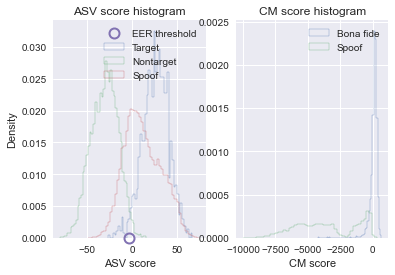

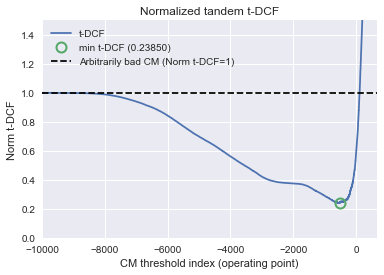

In [4]:
cqcc_gmm_50_score = '/Users/asimadnan/Desktop/Mres/Experiments/gmm_dev_50_scores.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'

evaluate_tDCF_asvspoof19(cqcc_gmm_50_score, dev_asv_score, False);   

## GMM SCORES with CQCC of Matlab, feature width 50

### EER % 6.35891	
### tDCF 0.18814

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

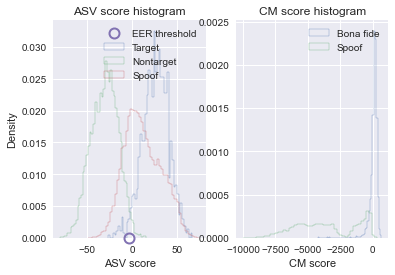

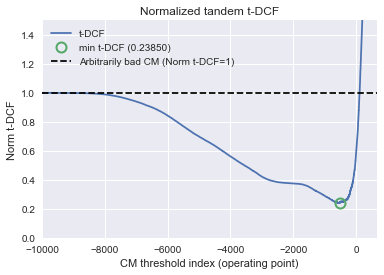

CM threshold at min TDCF is: -523.8747275117057


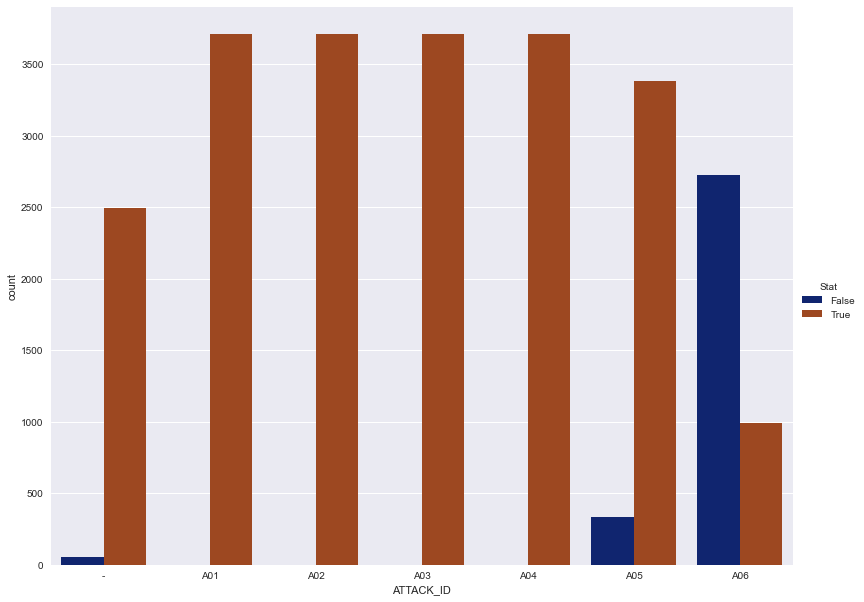

In [7]:
cqcc_gmm_50_score = '/Users/asimadnan/Desktop/Mres/Experiments/gmm_dev_50_scores.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
error_analysis(cqcc_gmm_50_score,dev_asv_score)


## GMM SCORES with CQCC of Matlab, feature width 150
### EER% 4.8687	
### tDCF 0.13763

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

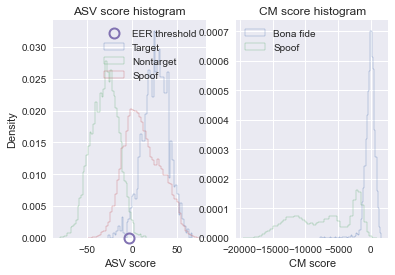

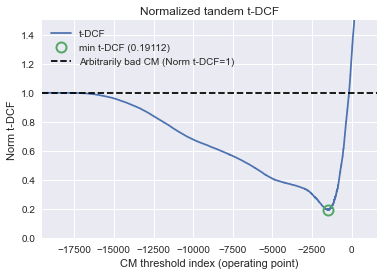

CM threshold at min TDCF is: -1463.7921488607317


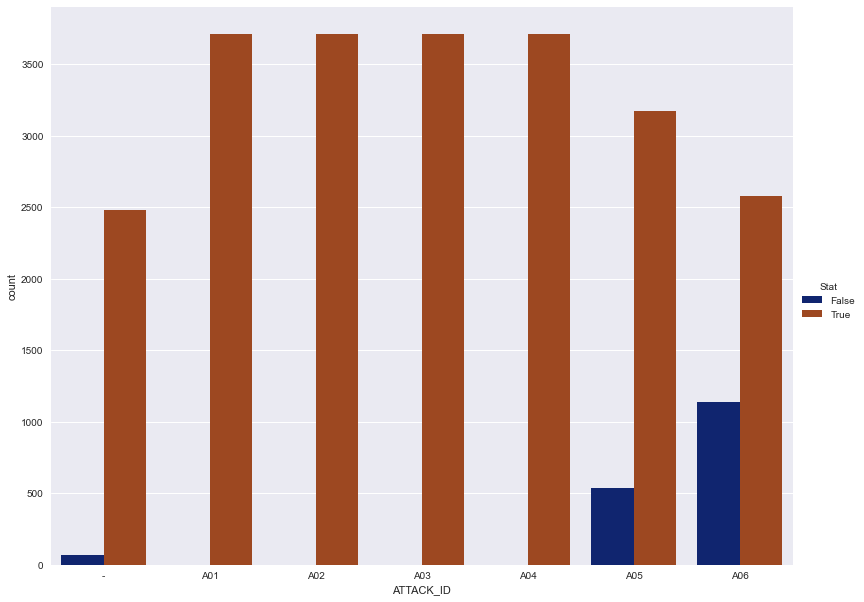

In [8]:
cqcc_gmm_150_score = '/Users/asimadnan/Desktop/Mres/Experiments/gmm_dev_150_scores.csv'
error_analysis(cqcc_gmm_150_score,dev_asv_score)

## GMM SCORES with CQCC of Matlab, feature width 300
### EER% 6.08324
### tDCF 0.20174


t-DCF evaluation from [Nbona=2548, Nspoof=21781] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

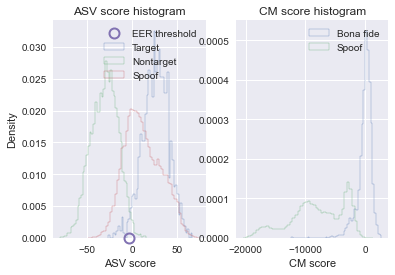

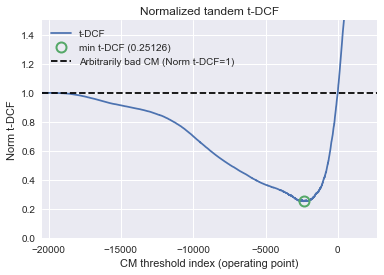

CM threshold at min TDCF is: -2361.2074941259925


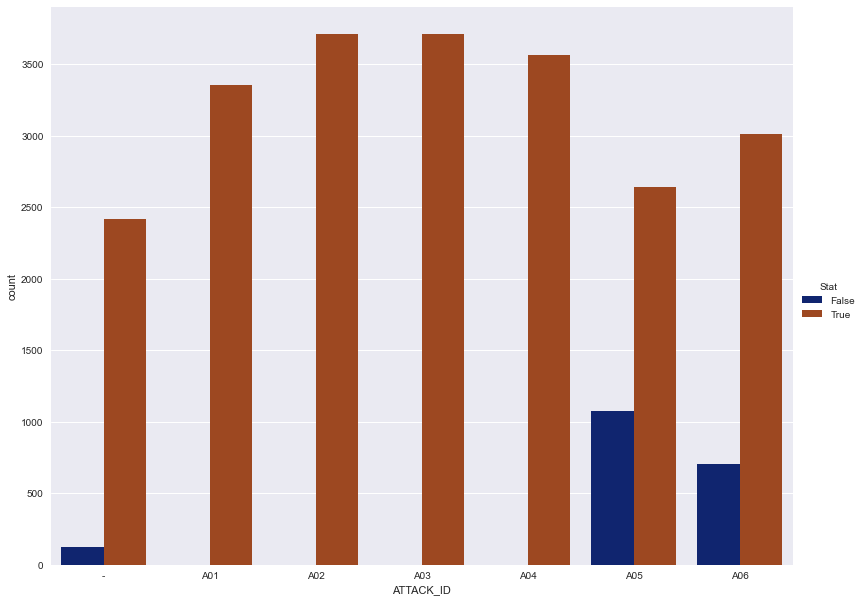

In [9]:
cqcc_gmm_300_score = '/Users/asimadnan/Desktop/Mres/Experiments/gmm_dev_300_scores.csv'
error_analysis(cqcc_gmm_300_score,dev_asv_score)

ID of the speech spoofing system (A01 - A19),  or, for bonafide speech SYSTEM-ID is left blank ('-')
Brief description on LA spoofing systems, where TTS and VC denote text-to-speech and voice-conversion systems:
- A01	TTS	neural waveform model
- A02	TTS	vocoder
- A03	TTS	vocoder
- A04	TTS	waveform concatenation
- A05	VC	vocoder
- A06	VC	spectral filtering

- A07	TTS	vocoder+GAN
- A08	TTS	neural waveform
- A09	TTS	vocoder
- A10	TTS	neural waveform
- A11	TTS	griffin lim
- A12	TTS	neural waveform
- A13	TTS_VC	waveform concatenation+waveform filtering
- A14	TTS_VC	vocoder
- A15	TTS_VC	neural waveform
- A16	TTS	waveform concatenation
- A17	VC	waveform filtering
- A18	VC	vocoder
- A19	VC	spectral filtering

# NNET Scores

## AlexNet
# activation relu
# dev data used as val data
# 50 epochs

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

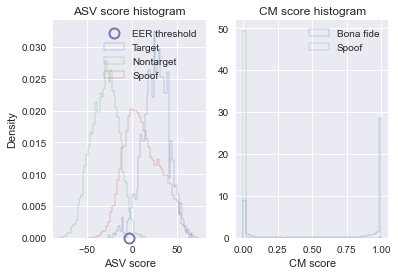

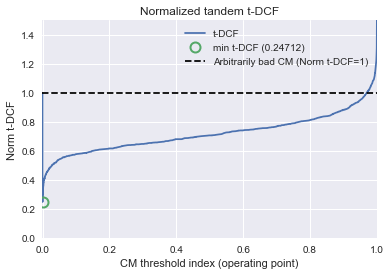

CM threshold at min TDCF is: 1.03401835e-05


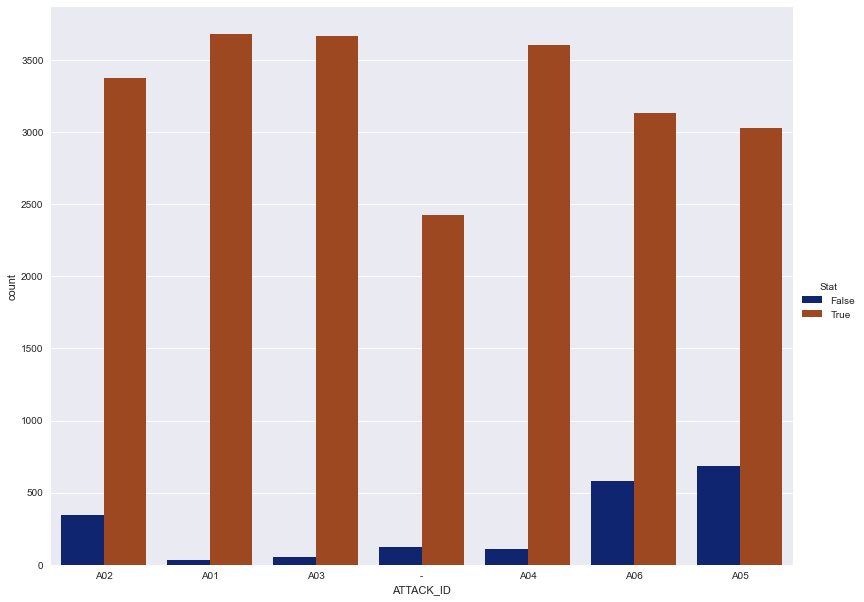

In [10]:
cqtt_nnet_50_score = '/Users/asimadnan/Desktop/Mres/tDCF_python_v1/cqt_dev_50_M4_scores.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
error_analysis(cqtt_nnet_50_score,dev_asv_score)


# NNet 
## LR 0.0001
## epoch 100
## val data dev
## relu

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

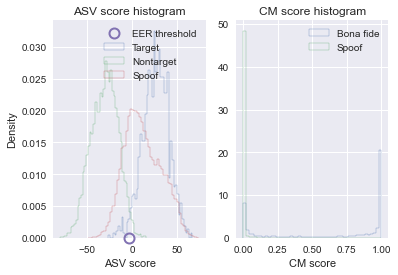

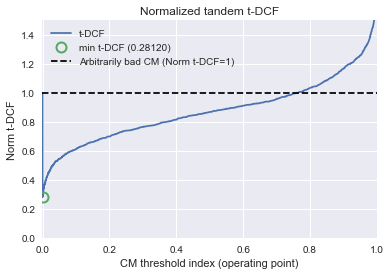

CM threshold at min TDCF is: 0.00019256228


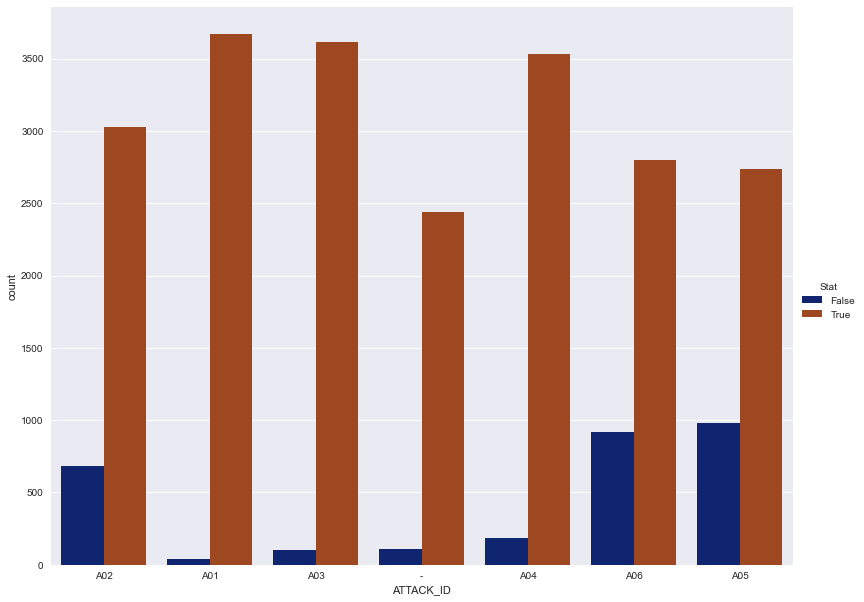

In [11]:
cqtt_nnet_50_score = '/Users/asimadnan/Desktop/Mres/tDCF_python_v1/cqt_dev_100_M5_scores.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
error_analysis(cqtt_nnet_50_score,dev_asv_score)


## NNet Raw Cqt 84x 300, 50 epochs

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

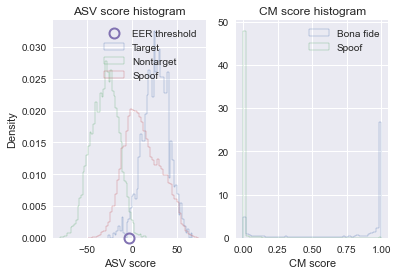

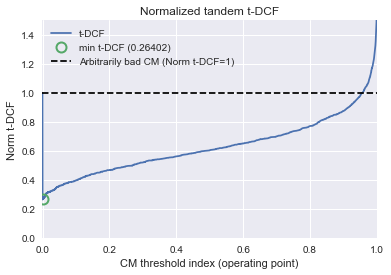

CM threshold at min TDCF is: 0.00048690938


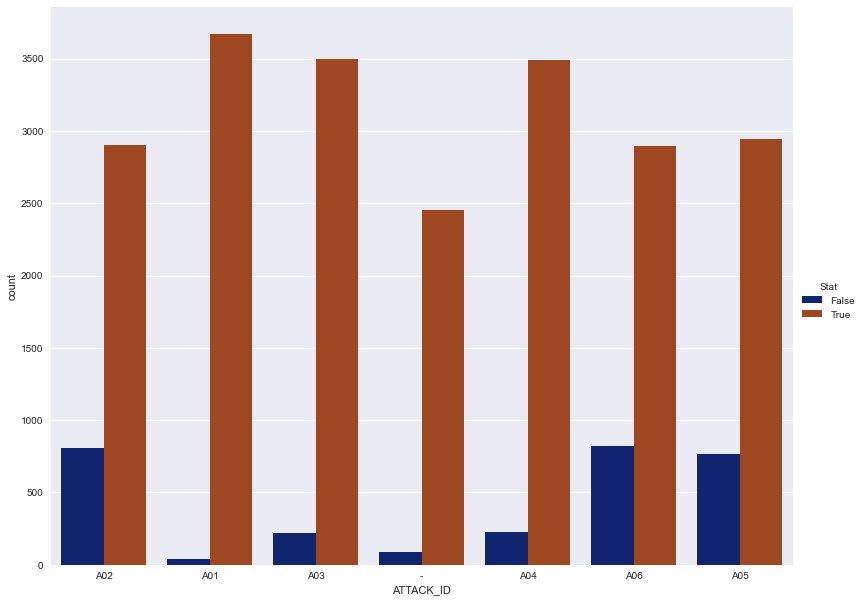

In [12]:
cqtt_nnet_50_score = '/Users/asimadnan/Desktop/Mres/tDCF_python_v1/cqt_dev_300_M6_scores.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
error_analysis(cqtt_nnet_50_score,dev_asv_score)


In [ ]:
# ensemble

In [13]:
cqcc_gmm_50_score = '/Users/asimadnan/Desktop/Mres/Experiments/gmm_dev_50_scores.csv'
cqtt_nnet_50_score = '/Users/asimadnan/Desktop/Mres/tDCF_python_v1/cqt_dev_50_M4_scores.csv'


In [14]:
scaler = MinMaxScaler()

In [15]:
cqcc_gmm = pd.read_csv(cqcc_gmm_50_score,delimiter = " ", header=None)
cqcc_gmm.columns = ['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']

In [16]:
cqt_cnn = pd.read_csv(cqtt_nnet_50_score,delimiter = " ", header=None)
cqt_cnn.columns = ['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']

In [17]:
merged = pd.merge(cqt_cnn,cqcc_gmm,on='AUDIO_FILE_NAME')

In [18]:
merged['SCORE'] = merged['SCORE_x'] + merged['SCORE_y']
merged = merged[['AUDIO_FILE_NAME','ATTACK_ID_x','KEY_x','SCORE']]
merged.columns = ['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']
merged.to_csv('merged.csv',index=False,sep=" ",header=False)

## Ensemble

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

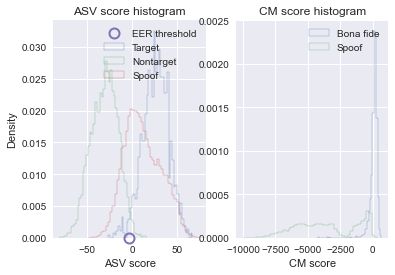

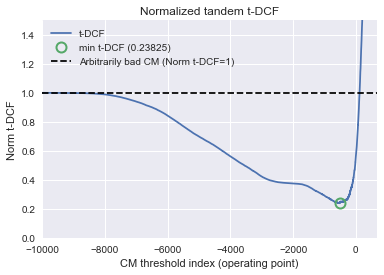

CM threshold at min TDCF is: -523.2102100278881


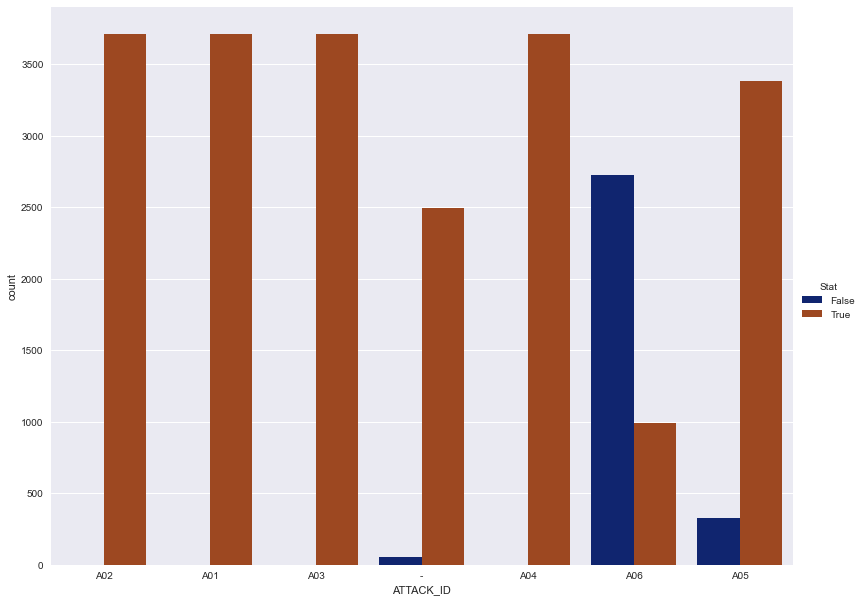

In [19]:
merged_score = 'merged.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
error_analysis(merged_score,dev_asv_score)


In [22]:
cqcc_gmm['SCORE'] = scaler.fit_transform(cqcc_gmm['SCORE'].values.reshape(-1,1))
cqt_cnn['SCORE'] = scaler.fit_transform(cqt_cnn['SCORE'].values.reshape(-1,1))
merged = pd.merge(cqt_cnn,cqcc_gmm,on='AUDIO_FILE_NAME')
merged['SCORE'] = merged['SCORE_x'] + merged['SCORE_y']
merged = merged[['AUDIO_FILE_NAME','ATTACK_ID_x','KEY_x','SCORE']]
merged.columns = ['AUDIO_FILE_NAME','ATTACK_ID','KEY','SCORE']
merged.to_csv('merged-scaled.csv',index=False,sep=" ",header=False)

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

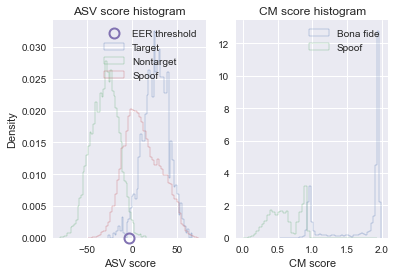

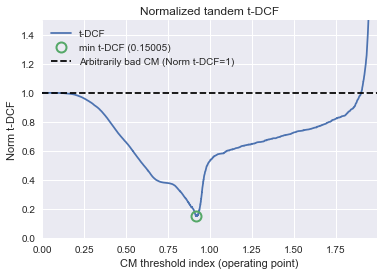

CM threshold at min TDCF is: 0.916167171114755


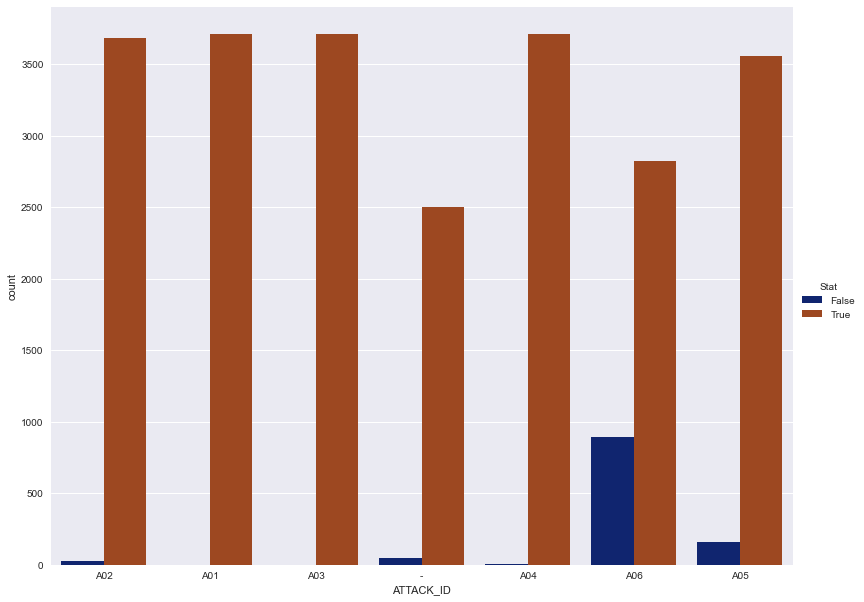

In [23]:
merged_score = 'merged-scaled.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
error_analysis(merged_score,dev_asv_score)


# Simple Spectrogram with CNN

- cut at 150
- 50 epoch 
- alexnet
- results on dev

t-DCF evaluation from [Nbona=2548, Nspoof=22296] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa          = 10.00000 (Cost of tandem system falsely accepting a nontarget)
   Cmiss        =  1.00000 (Cost of tandem system falsely rejecting target speaker)
   Cfa_spoof    = 10.00000 (Cost of tandem sysmte falsely accepting spoof)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), t_CM=CM threshold)
   tDCF_norm(t_CM) =  0.06203 +  2.25863 x Pmiss_cm(t_CM) +  0.93797 x Pfa_cm(t_CM)

     * The optimum value is given by the first term (0.06273). This is the normalized t-DCF obtained with an error-free CM system.
     * The minimum normalized cost (minimum over all possible thresholds) is always <= 1.00.

ASV SYSTEM
   EER            =  2.42653 % (Equal error rate (target vs. nontarget dis

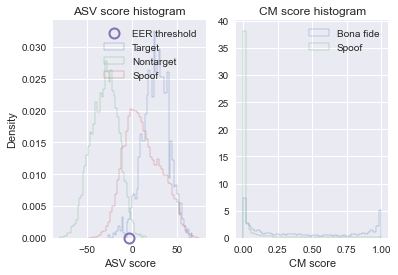

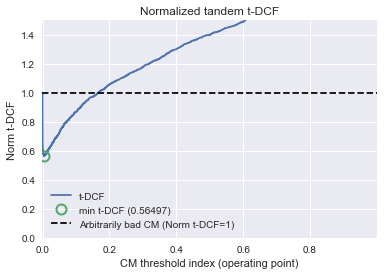

CM threshold at min TDCF is: 0.0047106766


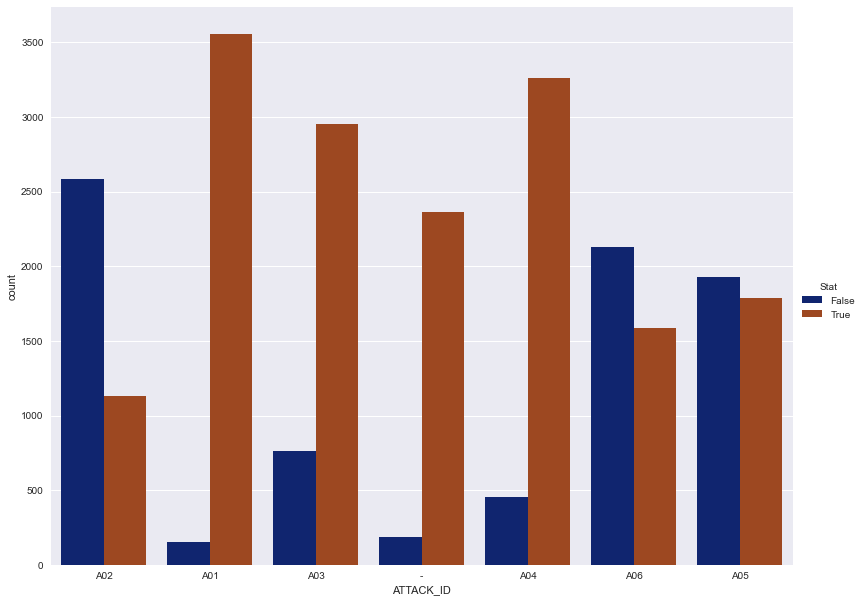

In [24]:
cnn_score = '/Users/asimadnan/Desktop/Mres/tDCF_python_v1/spectrogram-LA-train-150_scores.csv'
dev_asv_score = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.dev.gi.trl.scores.txt'
error_analysis(cnn_score,dev_asv_score)
